# Tutorial Denoising

> denoising


In [ ]:
#| default_exp tutorial_denoising

In [ ]:
from bioMONAI.data import *
from bioMONAI.transforms import *
from bioMONAI.core import *
from bioMONAI.core import Path
from bioMONAI.data import get_image_files, get_target, RandomSplitter
from bioMONAI.losses import *
from bioMONAI.losses import SSIMLoss
from bioMONAI.metrics import *
from bioMONAI.datasets import download_file


In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
device = get_device()
print(device)

cuda


### Download Data

In [ ]:
# Specify the directory where you want to save the downloaded files
output_directory = "../_data/U2OS"
# Define the base URL for the dataset
url = 'http://csbdeep.bioimagecomputing.com/example_data/snr_7_binning_2.zip'

# Download only the first two images
download_file(url, output_directory, extract=True)

The file has been downloaded and saved to: ../_data/U2OS
Decompression (if needed) has been handled automatically.


### Create Dataloader

In [ ]:
X_path = '../_data/U2OS/128a57f165e1044e34d9a6ef46e66b3c-snr_7_binning_2.zip.unzip/train/low/'

bs = 32
patch_size = 96

itemTfms = [RandCropND(patch_size), RandRot90(prob=.75), RandFlip(prob=0.75)]
batchTfms = [ScaleIntensityPercentiles()]

get_target_fn = get_target('GT', same_filename=True, relative_path=True)

data = BioDataLoaders.from_folder(
    X_path, 
    get_target_fn, 
    valid_pct=0.05, 
    seed=42, 
    item_tfms=itemTfms,
    batch_tfms=batchTfms, 
    show_summary=False,
    bs = bs,
    )

# print length of training and validation datasets
print('train images:', len(data.train_ds.items), '\nvalidation images:', len(data.valid_ds.items))

train images: 2335 
validation images: 122


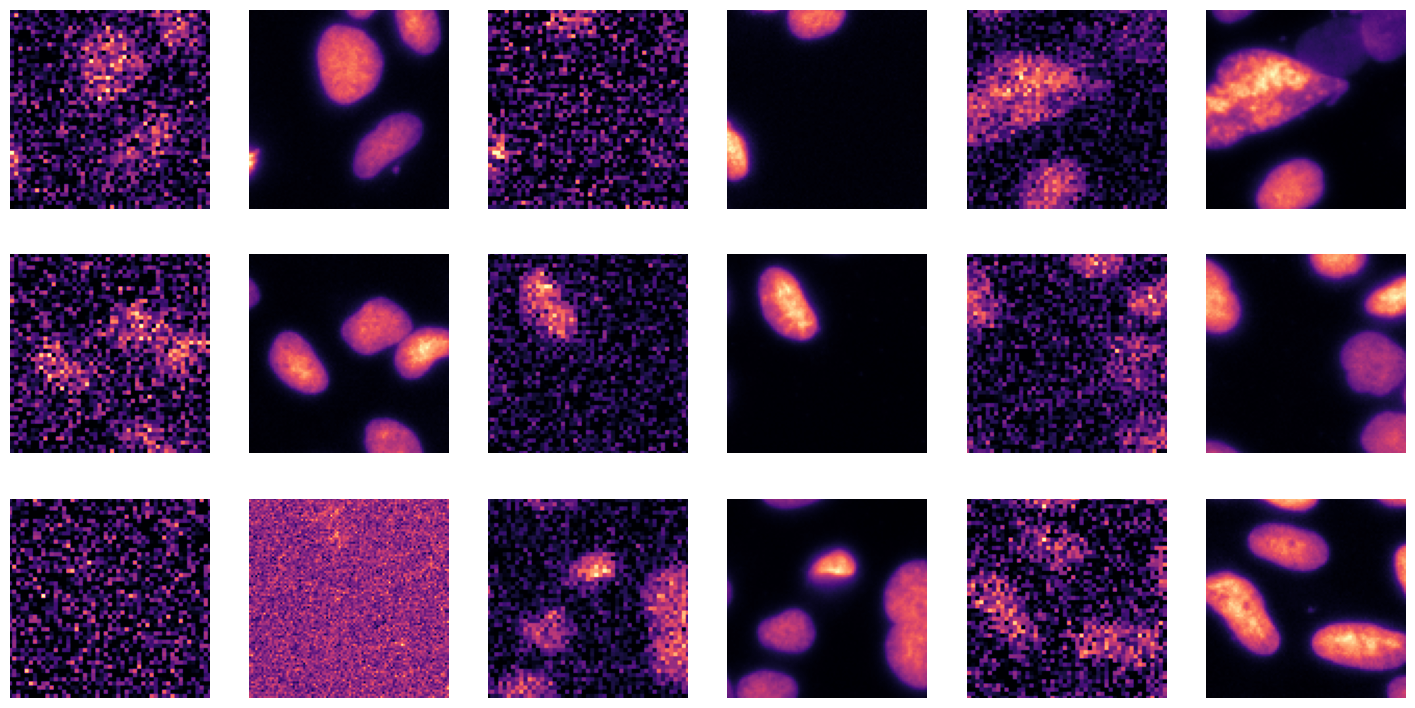

In [ ]:
data.show_batch(cmap='magma')

### Load and train a 2D model

In [ ]:
from bioMONAI.nets import create_unet_model, resnet34

model = create_unet_model(resnet34, 1, (128,128), True, n_in=1, cut=7)

In [ ]:
loss = CombinedLoss(mse_weight=0.8, mae_weight=0.1)

metrics = [MSEMetric(), MAEMetric(), SSIMMetric(2)]

trainer = fastTrainer(data, model, loss_fn=loss, metrics=metrics, show_summary=False)


epoch,train_loss,valid_loss,MSE,MAE,SSIM,time
0,0.059263,0.031750,0.003062,0.030812,0.737810,00:05
1,0.031509,0.021351,0.002592,0.025890,0.833123,00:04


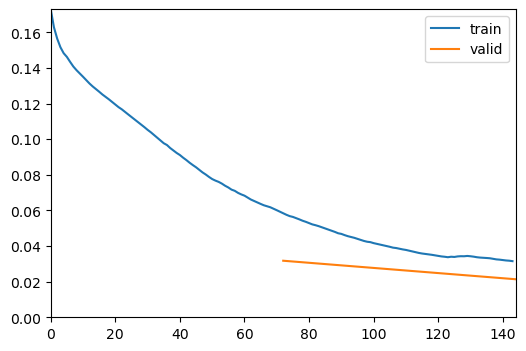

epoch,train_loss,valid_loss,MSE,MAE,SSIM,time
0,0.018390,0.017519,0.001561,0.020792,0.858087,00:04
1,0.016879,0.015520,0.001512,0.020095,0.876995,00:04
2,0.015920,0.016230,0.001825,0.021673,0.873977,00:04
3,0.015772,0.015743,0.001493,0.019981,0.874495,00:04
4,0.015445,0.018726,0.002763,0.026642,0.861489,00:04
5,0.015966,0.015048,0.001492,0.019624,0.881081,00:04
6,0.016098,0.016459,0.001995,0.022954,0.874330,00:04
7,0.015651,0.015040,0.001728,0.020668,0.884089,00:04
8,0.015609,0.016344,0.002146,0.022793,0.876518,00:04
9,0.015790,0.016388,0.001928,0.021907,0.873452,00:04


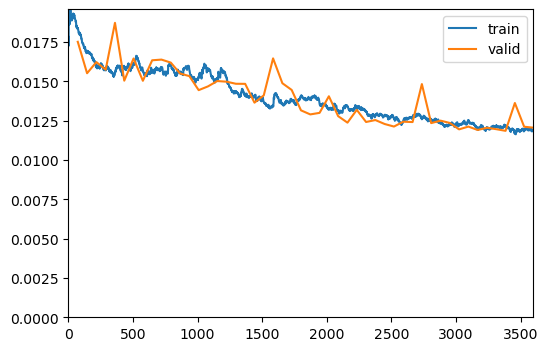

In [ ]:
trainer.fine_tune(50, freeze_epochs=2)

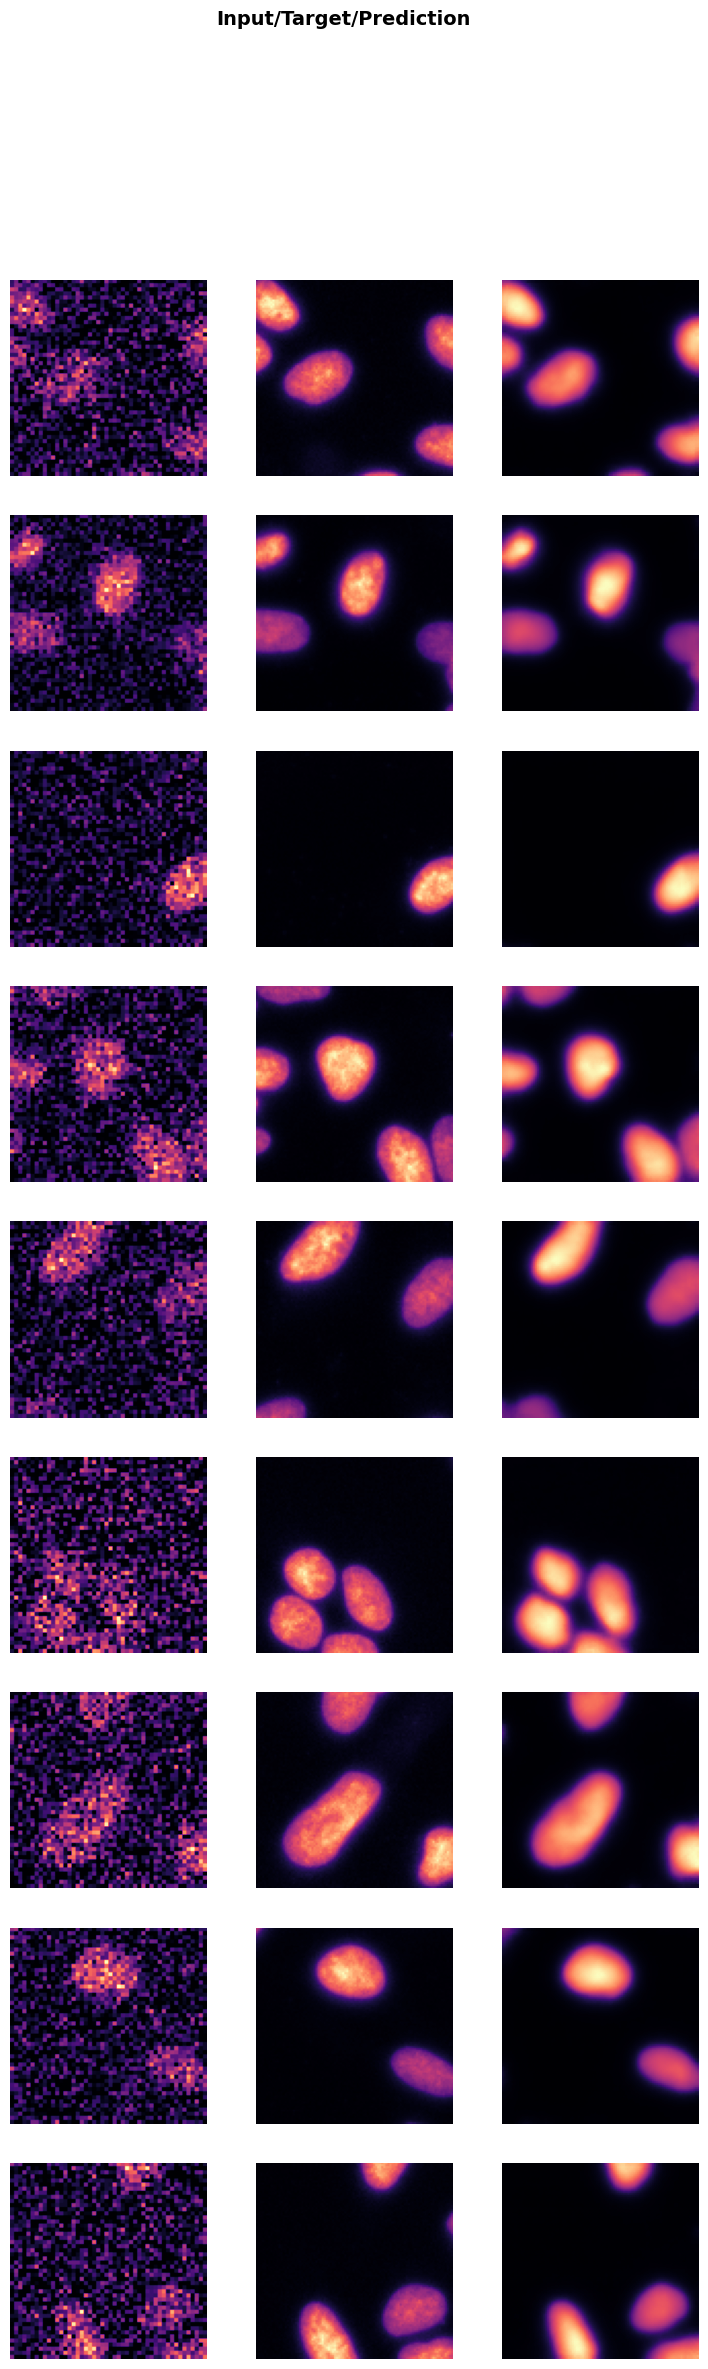

In [ ]:
trainer.show_results(cmap='magma')

In [ ]:
# trainer.save('tmp-model')

### Test data 
Evaluate the performance of the selected model on unseen data.
It’s important to not touch this data until you have fine tuned your model to get an unbiased evaluation!

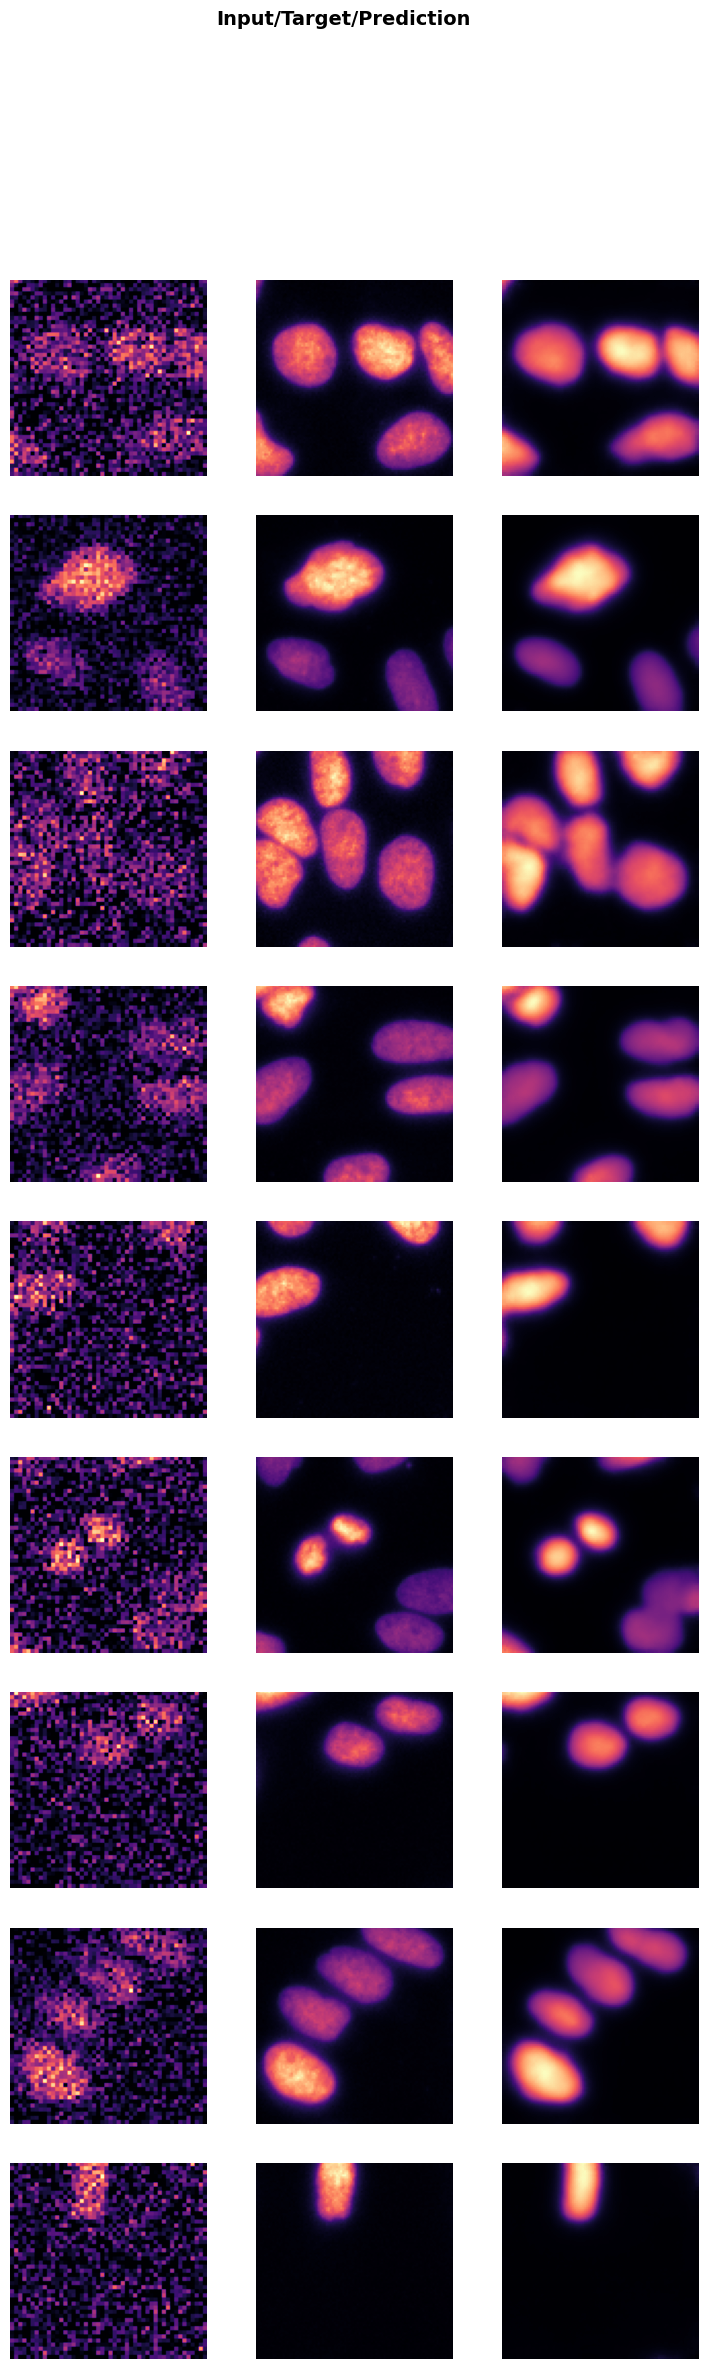

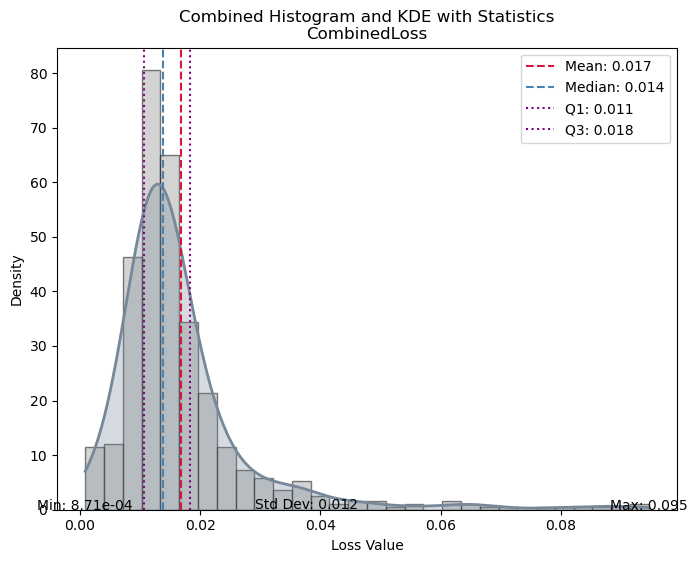

,Value
CombinedLoss,
Mean,0.016833
Median,0.013806
Standard Deviation,0.012330
Min,0.000871
Max,0.094672
Q1,0.010612
Q3,0.018312


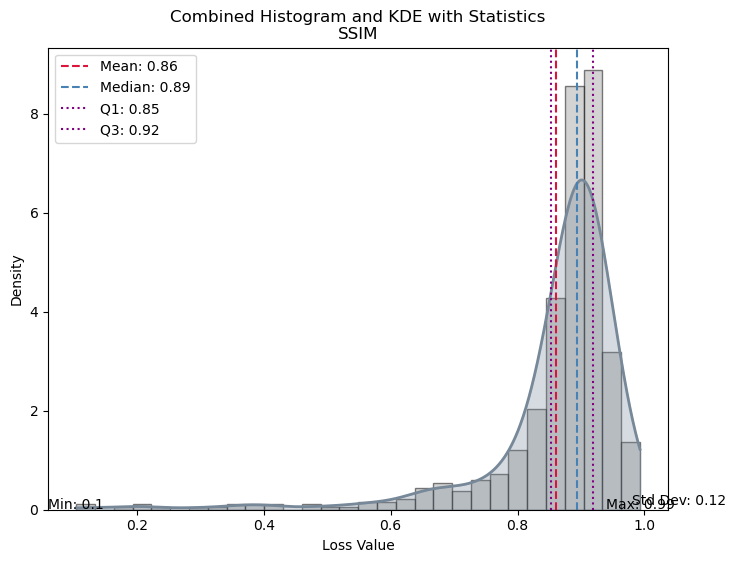

,Value
SSIM,
Mean,0.860965
Median,0.893404
Standard Deviation,0.118673
Min,0.104494
Max,0.992975
Q1,0.852688
Q3,0.918993


In [ ]:
test_X_path = '../_data/U2OS/128a57f165e1044e34d9a6ef46e66b3c-snr_7_binning_2.zip.unzip/test/low/'

test_data = data.test_dl(get_image_files(test_X_path), with_labels=True)

evaluate_model(trainer, test_data, metrics=SSIMMetric(2));